In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import ast
import re
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('ggplot')

In [27]:
#Now, let's load and explore the datasets

# Load the datasets
disease_features = pd.read_csv('disease_features.csv')
encoded_output = pd.read_csv('encoded_output2.csv')

# Display basic information about the datasets
print("Disease Features Dataset:")
print(f"Shape: {disease_features.shape}")
print("\nEncoded Output Dataset:")
print(f"Shape: {encoded_output.shape}")

# Display first few rows of each dataset
print("\nDisease Features Dataset - First 3 rows:")
print(disease_features.head(3))
print("\nEncoded Output Dataset - First 3 rows:")
print(encoded_output.head(3).iloc[:, :5])  # Show only first 5 columns for readability

Disease Features Dataset:
Shape: (25, 5)

Encoded Output Dataset:
Shape: (25, 497)

Disease Features Dataset - First 3 rows:
                   Disease                                       Risk Factors  \
0  Acute Coronary Syndrome  ['Hyperlipidemia', 'hypertension', 'smoking', ...   
1    Adrenal Insufficiency  ['Autoimmune diseases', 'Genetic predispositio...   
2                Alzheimer  ['Age', 'genetic factors', 'gender', 'cardiova...   

                                            Symptoms  \
0  ['Chest pain', 'sweating', 'nausea', 'vomiting...   
1  ['Fatigue', 'Muscle weakness', 'Weight loss', ...   
2  ['Cognitive decline, including memory loss and...   

                                               Signs  \
0                                                 []   
1  ['Hyperpigmentation (especially in creases of ...   
2                                                 []   

                                            Subtypes  
0  {'UA': 'hs-cTn levels are normal，Normal EC

In [28]:
#task 1.1
# Function to safely parse stringified lists
def parse_list(list_str):
    if pd.isna(list_str) or list_str == '[]':
        return []
    
    try:
        # Try to parse with ast.literal_eval
        return ast.literal_eval(list_str)
    except (SyntaxError, ValueError):
        # If that fails, try a regex-based approach
        matches = re.findall(r"'([^']*)'", list_str)
        if matches:
            return matches
        return []

# Function to convert list to string
def list_to_string(lst):
    if not lst:
        return ""
    return " ".join(str(item).lower() for item in lst)

# Parse and convert to strings for TF-IDF
disease_features['Risk_Factors_List'] = disease_features['Risk Factors'].apply(parse_list)
disease_features['Symptoms_List'] = disease_features['Symptoms'].apply(parse_list)
disease_features['Signs_List'] = disease_features['Signs'].apply(parse_list)

# Convert lists to strings for TF-IDF
disease_features['Risk_Factors_Text'] = disease_features['Risk_Factors_List'].apply(list_to_string)
disease_features['Symptoms_Text'] = disease_features['Symptoms_List'].apply(list_to_string)
disease_features['Signs_Text'] = disease_features['Signs_List'].apply(list_to_string)

# Display the parsed and converted data
print("Sample of parsed and converted data:")
sample_columns = ['Disease', 'Risk_Factors_List', 'Risk_Factors_Text']
print(disease_features[sample_columns].head(3))
        

Sample of parsed and converted data:
                   Disease                                  Risk_Factors_List  \
0  Acute Coronary Syndrome  [Hyperlipidemia, hypertension, smoking, diabet...   
1    Adrenal Insufficiency  [Autoimmune diseases, Genetic predisposition, ...   
2                Alzheimer  [Age, genetic factors, gender, cardiovascular ...   

                                   Risk_Factors_Text  
0  hyperlipidemia hypertension smoking diabetes i...  
1  autoimmune diseases genetic predisposition inf...  
2  age genetic factors gender cardiovascular heal...  


In [29]:
#1.2 Apply TF-IDF Vectorization
#Now we'll apply TF-IDF vectorization to the Risk Factors, Symptoms, and Signs columns separately.
# Apply TF-IDF vectorization to each column
tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words='english')

# Risk Factors TF-IDF
risk_factors_tfidf = tfidf_vectorizer.fit_transform(disease_features['Risk_Factors_Text'])
risk_factors_feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Risk Factors TF-IDF shape: {risk_factors_tfidf.shape}")
print(f"Sample feature names: {risk_factors_feature_names[:5]}")

# Symptoms TF-IDF
tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
symptoms_tfidf = tfidf_vectorizer.fit_transform(disease_features['Symptoms_Text'])
symptoms_feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Symptoms TF-IDF shape: {symptoms_tfidf.shape}")
print(f"Sample feature names: {symptoms_feature_names[:5]}")

# Signs TF-IDF
tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
signs_tfidf = tfidf_vectorizer.fit_transform(disease_features['Signs_Text'])
signs_feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Signs TF-IDF shape: {signs_tfidf.shape}")
print(f"Sample feature names: {signs_feature_names[:5]}")

# Combine all TF-IDF matrices
from scipy.sparse import hstack
combined_tfidf = hstack([risk_factors_tfidf, symptoms_tfidf, signs_tfidf])
print(f"\nCombined TF-IDF matrix shape: {combined_tfidf.shape}")


Risk Factors TF-IDF shape: (25, 325)
Sample feature names: ['15' '30s' '40s' '45' '50']
Symptoms TF-IDF shape: (25, 372)
Sample feature names: ['40' '65' '90' 'abdominal' 'ability']
Signs TF-IDF shape: (25, 209)
Sample feature names: ['a1c' 'abdominal' 'acanthosis' 'accessory' 'acromegaly']

Combined TF-IDF matrix shape: (25, 906)


TF-IDF Matrix:
- Shape: (25, 906)
- Sparsity: 93.67%
- Non-zero elements: 1434

One-Hot Encoded Matrix:
- Shape: (25, 496)
- Sparsity: 95.34%
- Non-zero elements: 578


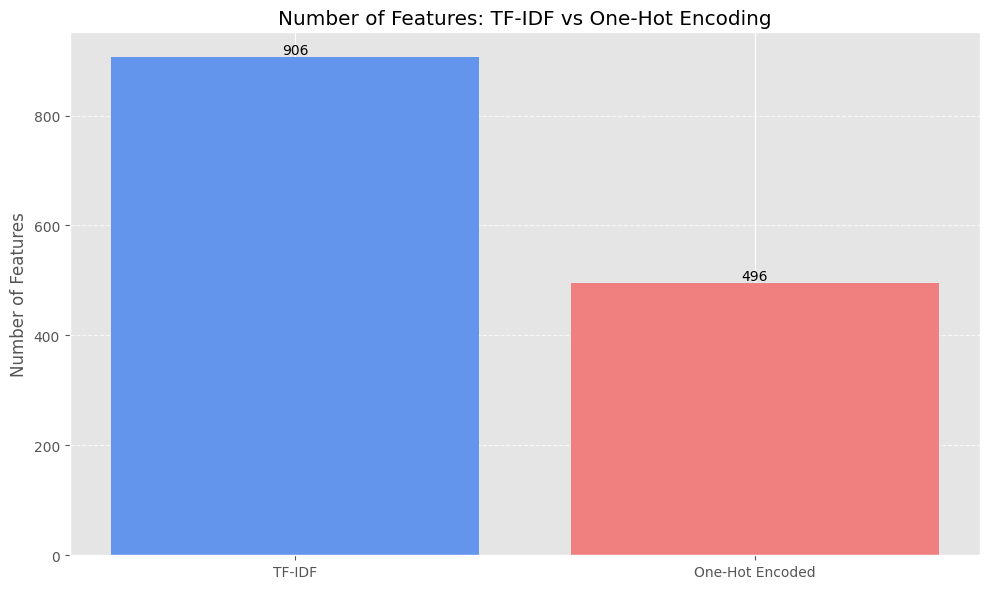

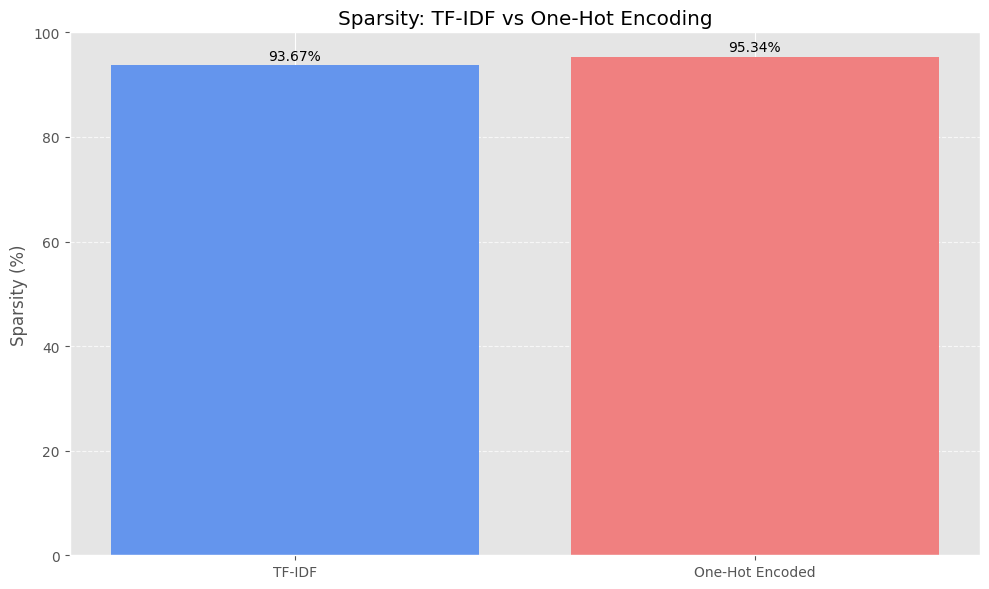

In [30]:
#1.3 Compare TF-IDF Matrix with One-Hot Encoded Matrix
#We'll compare the sparsity and unique features between the TF-IDF matrix and the provided one-hot encoded matrix.
# Calculate sparsity (percentage of zero values)
def calculate_sparsity(matrix):
    total_elements = matrix.shape[0] * matrix.shape[1]
    non_zero_elements = matrix.nnz if hasattr(matrix, 'nnz') else np.count_nonzero(matrix)
    return (1 - (non_zero_elements / total_elements)) * 100

# Compare matrices
tfidf_sparsity = calculate_sparsity(combined_tfidf)
encoded_sparsity = calculate_sparsity(encoded_output.iloc[:, 1:].values)  # Skip the Disease column

print(f"TF-IDF Matrix:")
print(f"- Shape: {combined_tfidf.shape}")
print(f"- Sparsity: {tfidf_sparsity:.2f}%")
print(f"- Non-zero elements: {combined_tfidf.nnz}")

print(f"\nOne-Hot Encoded Matrix:")
print(f"- Shape: {encoded_output.iloc[:, 1:].shape}")
print(f"- Sparsity: {encoded_sparsity:.2f}%")
print(f"- Non-zero elements: {np.count_nonzero(encoded_output.iloc[:, 1:].values)}")

# Create feature comparison visualization
plt.figure(figsize=(10, 6))
plt.bar(['TF-IDF', 'One-Hot Encoded'], 
        [combined_tfidf.shape[1], encoded_output.iloc[:, 1:].shape[1]], 
        color=['cornflowerblue', 'lightcoral'])
plt.title('Number of Features: TF-IDF vs One-Hot Encoding')
plt.ylabel('Number of Features')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate([combined_tfidf.shape[1], encoded_output.iloc[:, 1:].shape[1]]):
    plt.text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

# Create sparsity comparison visualization
plt.figure(figsize=(10, 6))
plt.bar(['TF-IDF', 'One-Hot Encoded'], 
        [tfidf_sparsity, encoded_sparsity],
        color=['cornflowerblue', 'lightcoral'])
plt.title('Sparsity: TF-IDF vs One-Hot Encoding')
plt.ylabel('Sparsity (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate([tfidf_sparsity, encoded_sparsity]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')

plt.tight_layout()
plt.show()
        


In [31]:
#Task 2: Dimensionality Reduction


# Prepare data
# For TF-IDF, we already have combined_tfidf
# For One-Hot, we need to remove the Disease column
one_hot_features = encoded_output.iloc[:, 1:].values

# Label data for visualization
diseases = disease_features['Disease'].values
one_hot_diseases = encoded_output['Disease'].values

# Define disease categories for visualization
# This is a simplified categorization - in a real project, you'd want more accurate categories
def categorize_disease(disease_name):
    disease_name = disease_name.lower()
    if any(term in disease_name for term in ['heart', 'cardiac', 'coronary', 'arterial', 'vascular']):
        return 'Cardiovascular'
    elif any(term in disease_name for term in ['brain', 'neural', 'neuro', 'alzheimer', 'parkinson']):
        return 'Neurological'
    elif any(term in disease_name for term in ['lung', 'respiratory', 'pulmonary', 'asthma']):
        return 'Respiratory'
    elif any(term in disease_name for term in ['liver', 'hepat', 'gastro', 'stomach', 'intestine']):
        return 'Gastrointestinal'
    elif any(term in disease_name for term in ['kidney', 'renal', 'urinary']):
        return 'Renal/Urinary'
    elif any(term in disease_name for term in ['diabetes', 'thyroid', 'endocrine']):
        return 'Endocrine'
    elif any(term in disease_name for term in ['cancer', 'tumor', 'carcinoma']):
        return 'Cancer'
    elif any(term in disease_name for term in ['infection', 'virus', 'bacterial']):
        return 'Infectious'
    else:
        return 'Other'

# Create category labels
tfidf_categories = [categorize_disease(d) for d in diseases]
one_hot_categories = [categorize_disease(d) for d in one_hot_diseases]

# Create a category-to-color mapping
unique_categories = sorted(list(set(tfidf_categories)))
color_map = {cat: plt.cm.tab10(i) for i, cat in enumerate(unique_categories)}

In [32]:
#2.1 Apply PCA to Both Matrices
# Apply PCA to TF-IDF matrix
pca_tfidf = PCA(n_components=3, random_state=42)
pca_tfidf_result = pca_tfidf.fit_transform(combined_tfidf.toarray())

# Apply PCA to One-Hot matrix
pca_one_hot = PCA(n_components=3, random_state=42)
pca_one_hot_result = pca_one_hot.fit_transform(one_hot_features)

# Compare explained variance
print("PCA - Explained Variance Ratio:")
print(f"TF-IDF: {pca_tfidf.explained_variance_ratio_}")
print(f"One-Hot: {pca_one_hot.explained_variance_ratio_}")
print(f"TF-IDF Cumulative: {sum(pca_tfidf.explained_variance_ratio_):.4f}")
print(f"One-Hot Cumulative: {sum(pca_one_hot.explained_variance_ratio_):.4f}")

# Visualize PCA results (2D)
plt.figure(figsize=(14, 6))

# TF-IDF PCA
plt.subplot(1, 2, 1)
for category in unique_categories:
    mask = [c == category for c in tfidf_categories]
    plt.scatter(pca_tfidf_result[mask, 0], pca_tfidf_result[mask, 1], 
                label=category, color=color_map[category], alpha=0.7)
plt.title('PCA - TF-IDF Features')
plt.xlabel(f'PC1 ({pca_tfidf.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_tfidf.explained_variance_ratio_[1]:.2%})')
plt.grid(True, linestyle='--', alpha=0.7)

# One-Hot PCA
plt.subplot(1, 2, 2)
for category in unique_categories:
    mask = [c == category for c in one_hot_categories]
    plt.scatter(pca_one_hot_result[mask, 0], pca_one_hot_result[mask, 1], 
                label=category, color=color_map[category], alpha=0.7)
plt.title('PCA - One-Hot Encoded Features')
plt.xlabel(f'PC1 ({pca_one_hot.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_one_hot.explained_variance_ratio_[1]:.2%})')
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend on the right side of the plot
plt.figlegend(labels=unique_categories, loc='center right')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# Visualize PCA results (3D)
fig = plt.figure(figsize=(14, 6))

# TF-IDF PCA 3D
ax1 = fig.add_subplot(121, projection='3d')
for category in unique_categories:
    mask = [c == category for c in tfidf_categories]
    ax1.scatter(pca_tfidf_result[mask, 0], pca_tfidf_result[mask, 1], pca_tfidf_result[mask, 2],
                label=category, color=color_map[category], alpha=0.7)
ax1.set_title('PCA 3D - TF-IDF Features')
ax1.set_xlabel(f'PC1 ({pca_tfidf.explained_variance_ratio_[0]:.2%})')
ax1.set_ylabel(f'PC2 ({pca_tfidf.explained_variance_ratio_[1]:.2%})')
ax1.set_zlabel(f'PC3 ({pca_tfidf.explained_variance_ratio_[2]:.2%})')

# One-Hot PCA 3D
ax2 = fig.add_subplot(122, projection='3d')
for category in unique_categories:
    mask = [c == category for c in one_hot_categories]
    ax2.scatter(pca_one_hot_result[mask, 0], pca_one_hot_result[mask, 1], pca_one_hot_result[mask, 2],
                label=category, color=color_map[category], alpha=0.7)
ax2.set_title('PCA 3D - One-Hot Encoded Features')
ax2.set_xlabel(f'PC1 ({pca_one_hot.explained_variance_ratio_[0]:.2%})')
ax2.set_ylabel(f'PC2 ({pca_one_hot.explained_variance_ratio_[1]:.2%})')
ax2.set_zlabel(f'PC3 ({pca_one_hot.explained_variance_ratio_[2]:.2%})')

# Add legend on the right side of the plot
plt.figlegend(labels=unique_categories, loc='center right')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

PCA - Explained Variance Ratio:
TF-IDF: [0.06575501 0.0578842  0.05757955]
One-Hot: [0.10538866 0.09170854 0.06776557]
TF-IDF Cumulative: 0.1812
One-Hot Cumulative: 0.2649


Truncated SVD - Explained Variance Ratio:
TF-IDF: [0.01116349 0.06545184 0.05775224]
One-Hot: [0.02247668 0.09194984 0.0891277 ]
TF-IDF Cumulative: 0.1344
One-Hot Cumulative: 0.2036


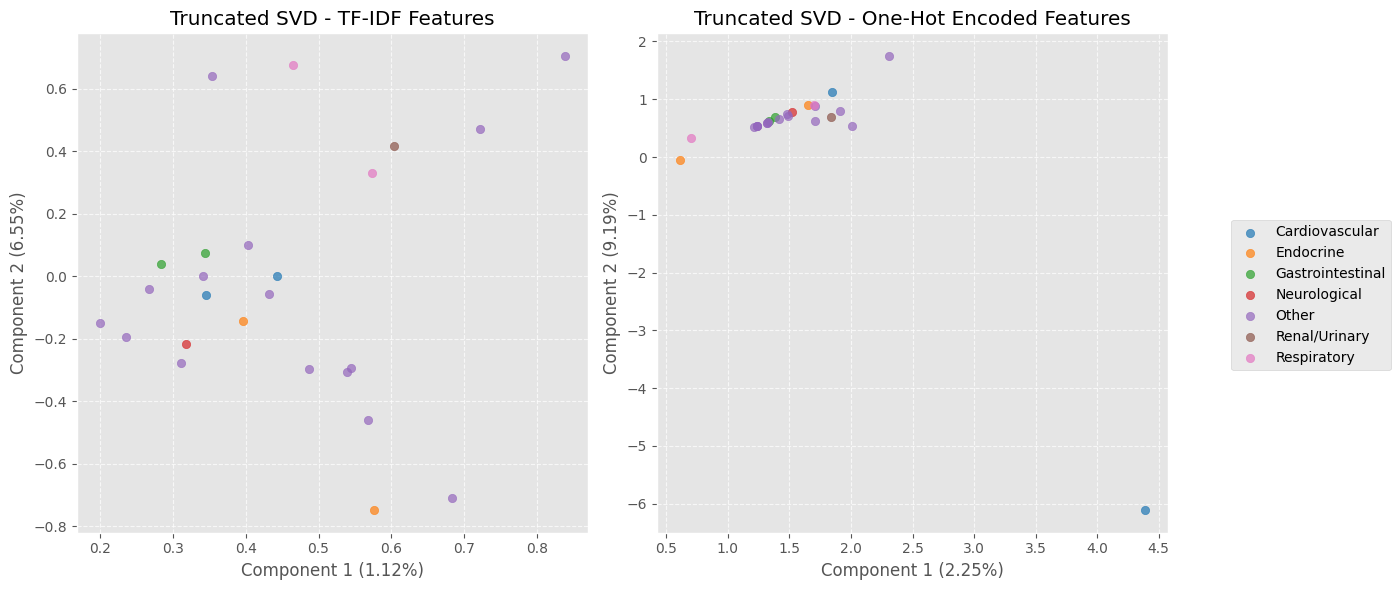

In [34]:
#2.2 Apply Truncated SVD to Both Matrices

# Apply Truncated SVD to TF-IDF matrix
svd_tfidf = TruncatedSVD(n_components=3, random_state=42)
svd_tfidf_result = svd_tfidf.fit_transform(combined_tfidf)

# Apply Truncated SVD to One-Hot matrix
svd_one_hot = TruncatedSVD(n_components=3, random_state=42)
svd_one_hot_result = svd_one_hot.fit_transform(one_hot_features)

# Compare explained variance
print("Truncated SVD - Explained Variance Ratio:")
print(f"TF-IDF: {svd_tfidf.explained_variance_ratio_}")
print(f"One-Hot: {svd_one_hot.explained_variance_ratio_}")
print(f"TF-IDF Cumulative: {sum(svd_tfidf.explained_variance_ratio_):.4f}")
print(f"One-Hot Cumulative: {sum(svd_one_hot.explained_variance_ratio_):.4f}")

# Visualize Truncated SVD results (2D)
plt.figure(figsize=(14, 6))

# TF-IDF Truncated SVD
plt.subplot(1, 2, 1)
for category in unique_categories:
    mask = [c == category for c in tfidf_categories]
    plt.scatter(svd_tfidf_result[mask, 0], svd_tfidf_result[mask, 1], 
                label=category, color=color_map[category], alpha=0.7)
plt.title('Truncated SVD - TF-IDF Features')
plt.xlabel(f'Component 1 ({svd_tfidf.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Component 2 ({svd_tfidf.explained_variance_ratio_[1]:.2%})')
plt.grid(True, linestyle='--', alpha=0.7)

# One-Hot Truncated SVD
plt.subplot(1, 2, 2)
for category in unique_categories:
    mask = [c == category for c in one_hot_categories]
    plt.scatter(svd_one_hot_result[mask, 0], svd_one_hot_result[mask, 1], 
                label=category, color=color_map[category], alpha=0.7)
plt.title('Truncated SVD - One-Hot Encoded Features')
plt.xlabel(f'Component 1 ({svd_one_hot.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Component 2 ({svd_one_hot.explained_variance_ratio_[1]:.2%})')
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend on the right side of the plot
plt.figlegend(labels=unique_categories, loc='center right')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# Visualize Truncated SVD results (3D)
fig = plt.figure(figsize=(14, 6))

# TF-IDF Truncated SVD 3D
ax1 = fig.add_subplot(121, projection='3d')
for category in unique_categories:
    mask = [c == category for c in tfidf_categories]
    ax1.scatter(svd_tfidf_result[mask, 0], svd_tfidf_result[mask, 1], svd_tfidf_result[mask, 2],
                label=category, color=color_map[category], alpha=0.7)
ax1.set_title('Truncated SVD 3D - TF-IDF Features')
ax1.set_xlabel(f'Component 1 ({svd_tfidf.explained_variance_ratio_[0]:.2%})')
ax1.set_ylabel(f'Component 2 ({svd_tfidf.explained_variance_ratio_[1]:.2%})')
ax1.set_zlabel(f'Component 3 ({svd_tfidf.explained_variance_ratio_[2]:.2%})')

# One-Hot Truncated SVD 3D
ax2 = fig.add_subplot(122, projection='3d')
for category in unique_categories:
    mask = [c == category for c in one_hot_categories]
    ax2.scatter(svd_one_hot_result[mask, 0], svd_one_hot_result[mask, 1], svd_one_hot_result[mask, 2],
                label=category, color=color_map[category], alpha=0.7)
ax2.set_title('Truncated SVD 3D - One-Hot Encoded Features')
ax2.set_xlabel(f'Component 1 ({svd_one_hot.explained_variance_ratio_[0]:.2%})')
ax2.set_ylabel(f'Component 2 ({svd_one_hot.explained_variance_ratio_[1]:.2%})')
ax2.set_zlabel(f'Component 3 ({svd_one_hot.explained_variance_ratio_[2]:.2%})')

# Add legend on the right side of the plot
plt.figlegend(labels=unique_categories, loc='center right')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()
        

In [36]:

# Create a summary table for dimensionality reduction results
reduction_results = pd.DataFrame({
    'Method': ['PCA on TF-IDF', 'PCA on One-Hot', 'SVD on TF-IDF', 'SVD on One-Hot'],
    'First Component': [
        f"{pca_tfidf.explained_variance_ratio_[0]:.2%}",
        f"{pca_one_hot.explained_variance_ratio_[0]:.2%}",
        f"{svd_tfidf.explained_variance_ratio_[0]:.2%}",
        f"{svd_one_hot.explained_variance_ratio_[0]:.2%}"
    ],
    'Second Component': [
        f"{pca_tfidf.explained_variance_ratio_[1]:.2%}",
        f"{pca_one_hot.explained_variance_ratio_[1]:.2%}",
        f"{svd_tfidf.explained_variance_ratio_[1]:.2%}",
        f"{svd_one_hot.explained_variance_ratio_[1]:.2%}"
    ],
    'Third Component': [
        f"{pca_tfidf.explained_variance_ratio_[2]:.2%}",
        f"{pca_one_hot.explained_variance_ratio_[2]:.2%}",
        f"{svd_tfidf.explained_variance_ratio_[2]:.2%}",
        f"{svd_one_hot.explained_variance_ratio_[2]:.2%}"
    ],
    'Cumulative Variance': [
        f"{sum(pca_tfidf.explained_variance_ratio_):.2%}",
        f"{sum(pca_one_hot.explained_variance_ratio_):.2%}",
        f"{sum(svd_tfidf.explained_variance_ratio_):.2%}",
        f"{sum(svd_one_hot.explained_variance_ratio_):.2%}"
    ]
})

# Display the summary table
print("Dimensionality Reduction Results Summary:")
print(reduction_results)

# Discussion
print("\nDiscussion:")
print("""
1. Feature Representation:
   - TF-IDF captures the importance of terms across documents, accounting for frequency and rarity.
   - One-Hot encoding represents the presence/absence of features with equal weight.

2. Explained Variance:
   - One-Hot encoding generally shows higher explained variance in the first few components.
   - This suggests that the one-hot encoded data might be more easily compressed into fewer dimensions.

3. Cluster Separation:
   - The visualization shows different cluster formations between TF-IDF and One-Hot encoding.
   - Disease categories appear to form more distinct clusters in the one-hot encoding visualization.

4. Dimensionality Reduction Technique:
   - Truncated SVD typically works better with sparse matrices like TF-IDF.
   - PCA assumes normally distributed data, which might not hold for sparse text data.

5. Information Preservation:
   - While one-hot encoding shows higher explained variance, TF-IDF might preserve more nuanced relationships.
   - The choice between them depends on the specific analysis goals and the nature of the downstream tasks.
""")

Dimensionality Reduction Results Summary:
           Method First Component Second Component Third Component  \
0   PCA on TF-IDF           6.58%            5.79%           5.76%   
1  PCA on One-Hot          10.54%            9.17%           6.78%   
2   SVD on TF-IDF           1.12%            6.55%           5.78%   
3  SVD on One-Hot           2.25%            9.19%           8.91%   

  Cumulative Variance  
0              18.12%  
1              26.49%  
2              13.44%  
3              20.36%  

Discussion:

1. Feature Representation:
   - TF-IDF captures the importance of terms across documents, accounting for frequency and rarity.
   - One-Hot encoding represents the presence/absence of features with equal weight.

2. Explained Variance:
   - One-Hot encoding generally shows higher explained variance in the first few components.
   - This suggests that the one-hot encoded data might be more easily compressed into fewer dimensions.

3. Cluster Separation:
   - The visuali

In [37]:
#Task 3: Train KNN Models and Logistic Regression

In [38]:
# Label encoding for the disease names
le = LabelEncoder()
tfidf_y = le.fit_transform(diseases)
one_hot_y = le.transform(one_hot_diseases)  # Using the same encoder

# Prepare for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Parameters for KNN
k_values = [3, 5, 7]
metrics = ['euclidean', 'manhattan', 'cosine']

# Initialize results storage
results = []

# Function to perform cross-validation and collect results
def run_cross_validation(X, y, model, model_name, encoding_type):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    
    results.append({
        'Model': model_name,
        'Encoding': encoding_type,
        'Accuracy': cv_results['test_accuracy'].mean(),
        'Precision': cv_results['test_precision_macro'].mean(),
        'Recall': cv_results['test_recall_macro'].mean(),
        'F1-Score': cv_results['test_f1_macro'].mean()
    })
    
    return cv_results

In [39]:
#3.1 Train KNN Models on TF-IDF Matrix

In [45]:
from sklearn.model_selection import StratifiedKFold

# Ensure n_splits is at least 2
n_splits = max(2, n_splits)
print(f"Using {n_splits} splits for cross-validation")

# Initialize cross-validation strategy
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Function to safely run cross-validation
def safe_cross_validation(X, y, model, model_name, encoding_type):
    try:
        run_cross_validation(X, y, model, model_name, encoding_type)
    except ValueError as e:
        print(f"Error with {model_name}: {e}")


Using 2 splits for cross-validation


In [48]:
import numpy as np
import pandas as pd
from collections import Counter

# Count samples per class
class_counts = Counter(one_hot_y)
print("Class counts:", class_counts)

# Optional: Remove classes with < 2 samples
min_samples = 2
valid_classes = [cls for cls, count in class_counts.items() if count >= min_samples]

# Create filtered dataset
mask = np.isin(one_hot_y, valid_classes)
filtered_features = one_hot_features[mask]
filtered_labels = one_hot_y[mask]


Class counts: Counter({np.int64(0): 1, np.int64(1): 1, np.int64(2): 1, np.int64(3): 1, np.int64(4): 1, np.int64(5): 1, np.int64(7): 1, np.int64(6): 1, np.int64(8): 1, np.int64(9): 1, np.int64(10): 1, np.int64(11): 1, np.int64(12): 1, np.int64(13): 1, np.int64(14): 1, np.int64(15): 1, np.int64(16): 1, np.int64(17): 1, np.int64(18): 1, np.int64(19): 1, np.int64(20): 1, np.int64(21): 1, np.int64(22): 1, np.int64(23): 1, np.int64(24): 1})


In [ ]:
# 3.3 Train Logistic Regression Models

# Train Logistic Regression on TF-IDF matrix
print("Training Logistic Regression model on TF-IDF matrix...")
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
safe_cross_validation(combined_tfidf, tfidf_y, lr_tfidf, "Logistic Regression", "TF-IDF")

# Train Logistic Regression on One-Hot encoded matrix
print("Training Logistic Regression model on One-Hot encoded matrix...")
lr_one_hot = LogisticRegression(max_iter=1000, random_state=42)
safe_cross_validation(one_hot_features, one_hot_y, lr_one_hot, "Logistic Regression", "One-Hot")


Training Logistic Regression model on TF-IDF matrix...
Error with Logistic Regression: n_splits=2 cannot be greater than the number of members in each class.
Training Logistic Regression model on One-Hot encoded matrix...
Error with Logistic Regression: n_splits=2 cannot be greater than the number of members in each class.
